# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [1]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

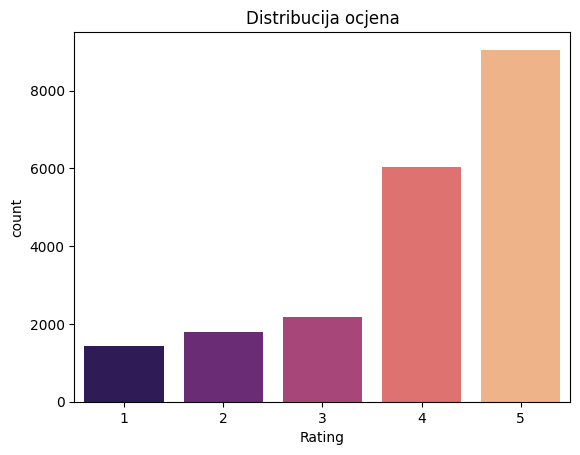

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

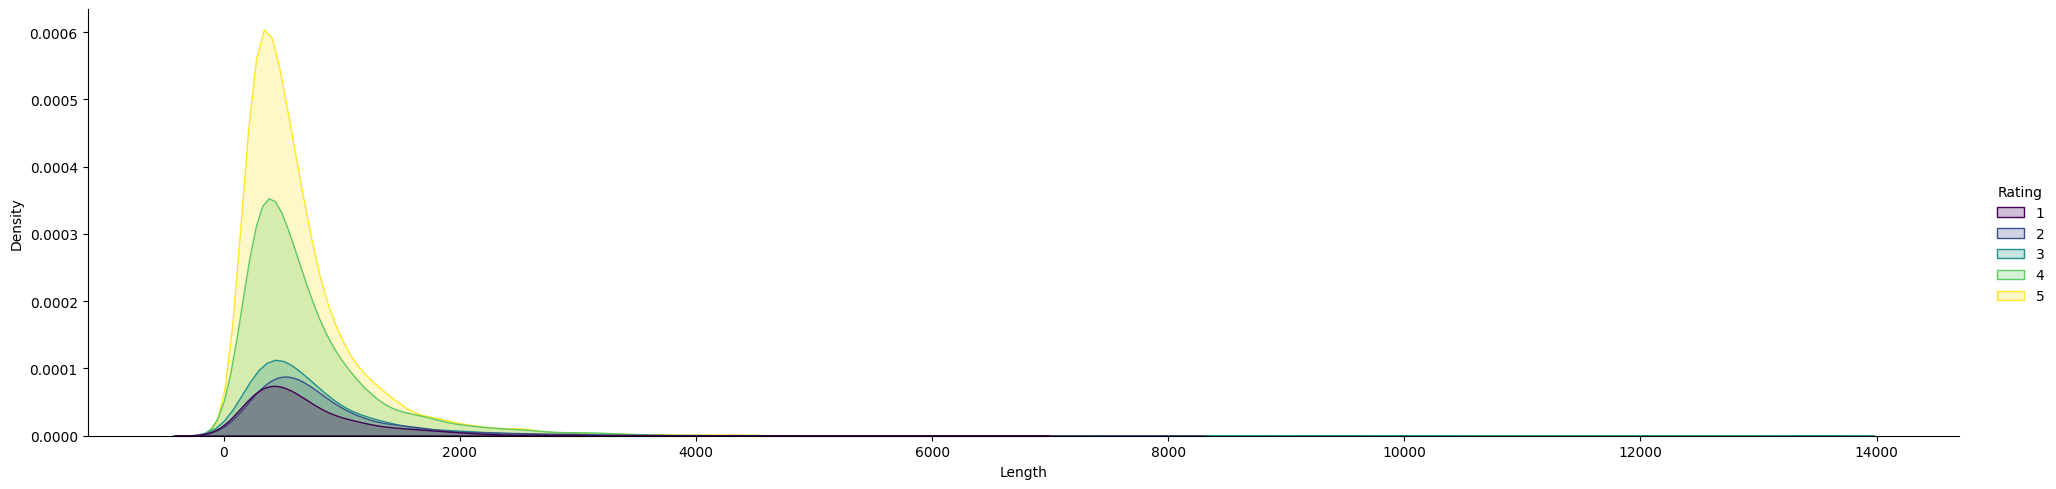

In [ ]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

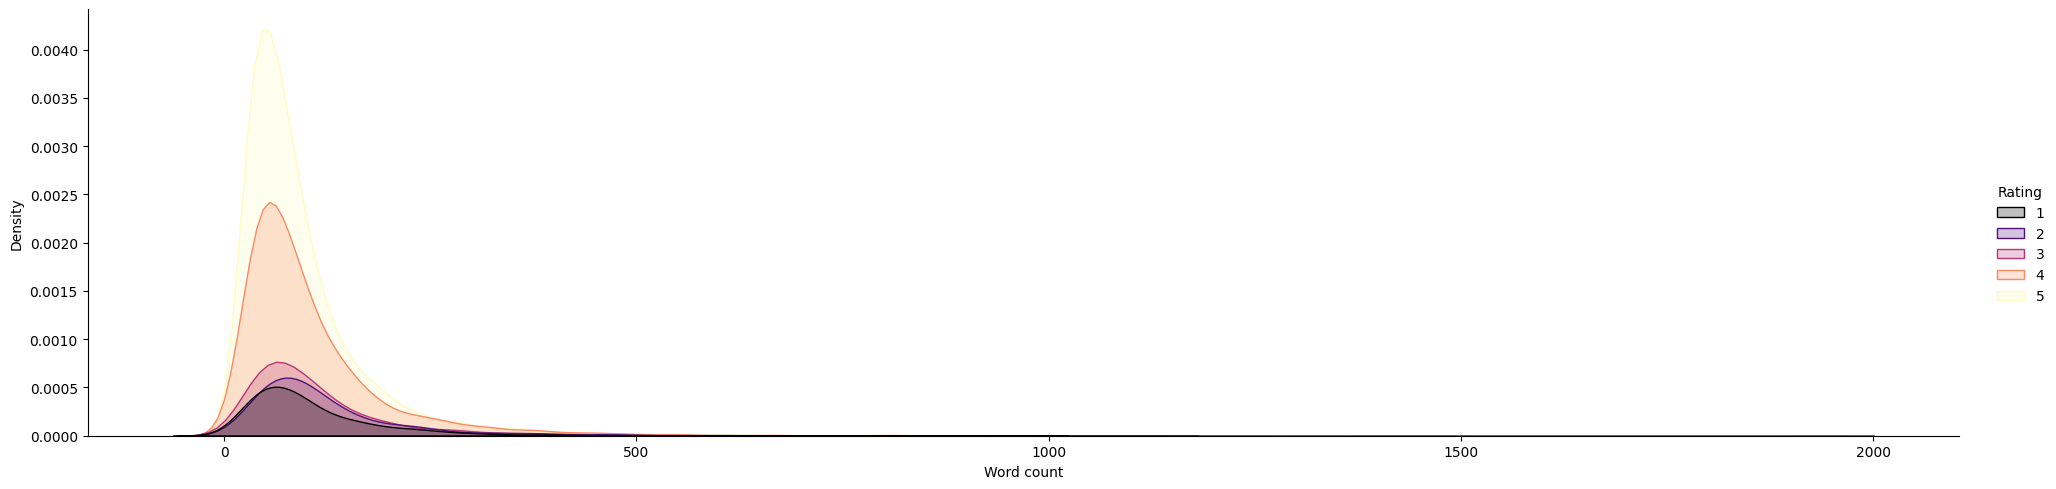

In [ ]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

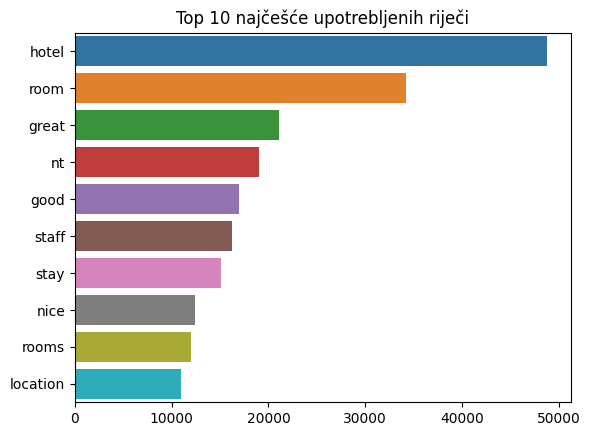

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

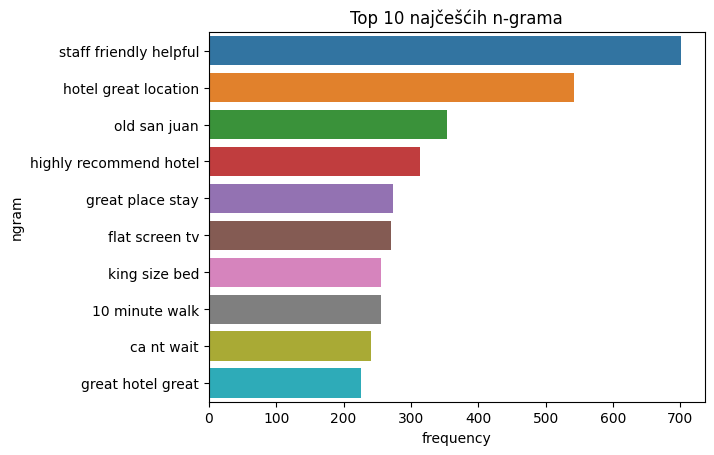

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

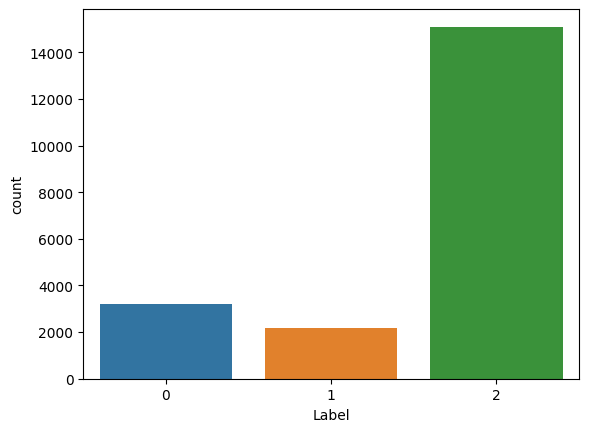

In [6]:
sns.countplot(x='Label', data=df);

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=72)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=72)

In [8]:
# Definirajte stopwords i izuzmite one koji utječu na sentiment
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very', 'really'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [9]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [10]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'day', 'time', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [11]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 275s 710ms/step - loss: 0.8479 - accuracy: 0.6908 - val_loss: 0.7476 - val_accuracy: 0.7457
Epoch 2/10
385/385 [==============================] - 257s 666ms/step - loss: 0.7403 - accuracy: 0.7539 - val_loss: 0.6295 - val_accuracy: 0.8036
Epoch 3/10
385/385 [==============================] - 252s 654ms/step - loss: 0.5917 - accuracy: 0.8023 - val_loss: 0.4993 - val_accuracy: 0.8277
Epoch 4/10
385/385 [==============================] - 246s 641ms/step - loss: 0.4681 - accuracy: 0.8395 - val_loss: 0.4482 - val_accuracy: 0.8377
Epoch 5/10
385/385 [==============================] - 251s 651ms/step - loss: 0.3811 - accuracy: 0.8614 - val_loss: 0.4720 - val_accuracy: 0.8267
Epoch 6/10
385/385 [==============================] - 249s 648ms/step - loss: 0.3095 - accuracy: 0.8827 - val_loss: 0.4853 - val_accuracy: 0.8331
Epoch 7/10
385/385 [==============================] - 252s 655ms/step - loss: 0.2537 - accuracy: 0.9042 - val_loss: 0.5162 -

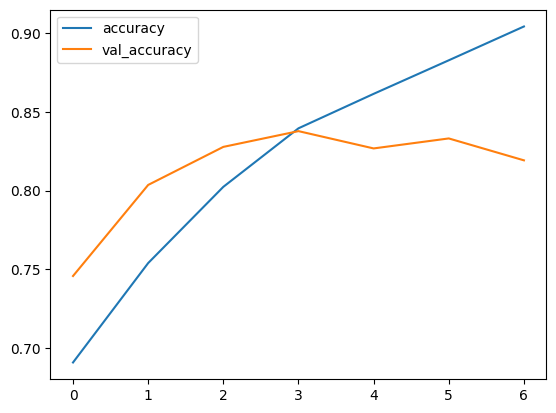

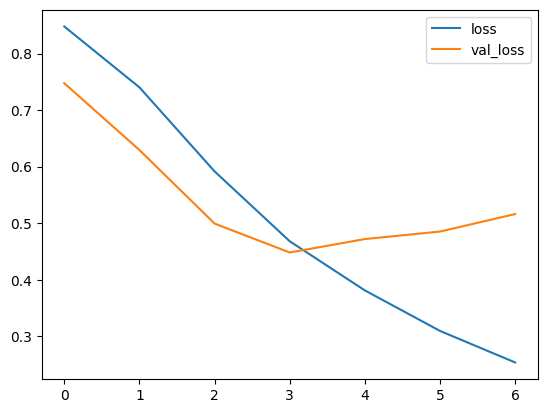

In [ ]:
rnn_model1 = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')])

rnn_model1.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model1.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = rnn_model1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 8s 64ms/step - loss: 0.5179 - accuracy: 0.8185
Test Loss: 0.5178619623184204
Test Accuracy: 0.8184922933578491


### GRU

Epoch 1/10
385/385 [==============================] - 43s 99ms/step - loss: 0.9034 - accuracy: 0.7413 - val_loss: 0.6677 - val_accuracy: 0.7457
Epoch 2/10
385/385 [==============================] - 20s 53ms/step - loss: 0.5606 - accuracy: 0.8041 - val_loss: 0.5019 - val_accuracy: 0.8370
Epoch 3/10
385/385 [==============================] - 15s 39ms/step - loss: 0.4975 - accuracy: 0.8178 - val_loss: 0.4745 - val_accuracy: 0.8404
Epoch 4/10
385/385 [==============================] - 14s 37ms/step - loss: 0.4528 - accuracy: 0.8289 - val_loss: 0.4798 - val_accuracy: 0.8302
Epoch 5/10
385/385 [==============================] - 12s 32ms/step - loss: 0.4273 - accuracy: 0.8407 - val_loss: 0.4804 - val_accuracy: 0.8392
Epoch 6/10
385/385 [==============================] - 12s 31ms/step - loss: 0.3998 - accuracy: 0.8659 - val_loss: 0.4882 - val_accuracy: 0.8380

Final val_accuracy: 83.80%



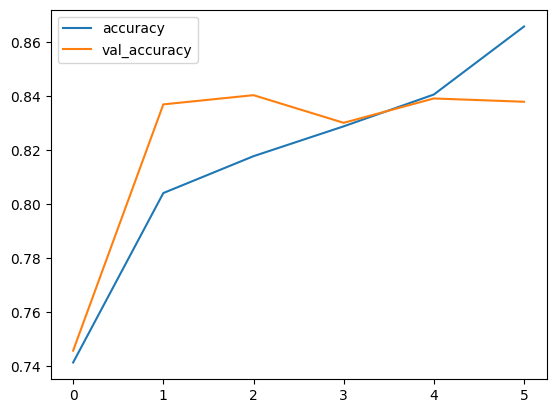

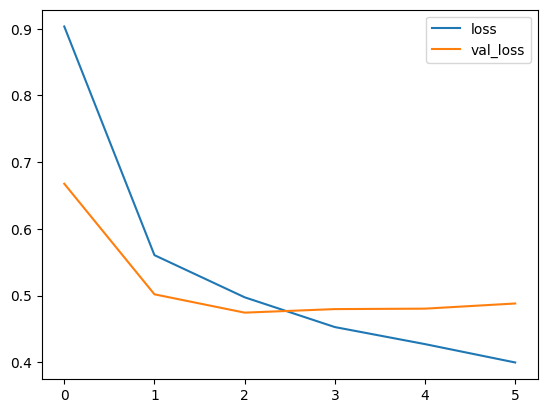

In [ ]:
gru_model2 = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    GRU(32),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

gru_model2.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model2.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = gru_model2.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 19ms/step - loss: 0.4885 - accuracy: 0.8329
Test Loss: 0.48853740096092224
Test Accuracy: 0.8328860402107239


## Dvosmjerna GRU mreža

Epoch 1/10
385/385 [==============================] - 53s 117ms/step - loss: 0.9393 - accuracy: 0.7923 - val_loss: 0.5185 - val_accuracy: 0.8397
Epoch 2/10
385/385 [==============================] - 29s 75ms/step - loss: 0.4518 - accuracy: 0.8585 - val_loss: 0.4684 - val_accuracy: 0.8433
Epoch 3/10
385/385 [==============================] - 23s 61ms/step - loss: 0.3885 - accuracy: 0.8724 - val_loss: 0.4390 - val_accuracy: 0.8482
Epoch 4/10
385/385 [==============================] - 20s 51ms/step - loss: 0.3557 - accuracy: 0.8822 - val_loss: 0.4396 - val_accuracy: 0.8509
Epoch 5/10
385/385 [==============================] - 21s 54ms/step - loss: 0.3235 - accuracy: 0.8971 - val_loss: 0.4527 - val_accuracy: 0.8446
Epoch 6/10
385/385 [==============================] - 20s 51ms/step - loss: 0.3031 - accuracy: 0.9061 - val_loss: 0.4755 - val_accuracy: 0.8458
Epoch 7/10
385/385 [==============================] - 18s 48ms/step - loss: 0.2733 - accuracy: 0.9156 - val_loss: 0.5108 - val_accuracy

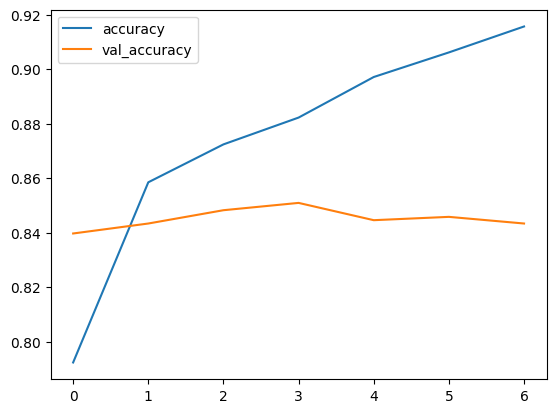

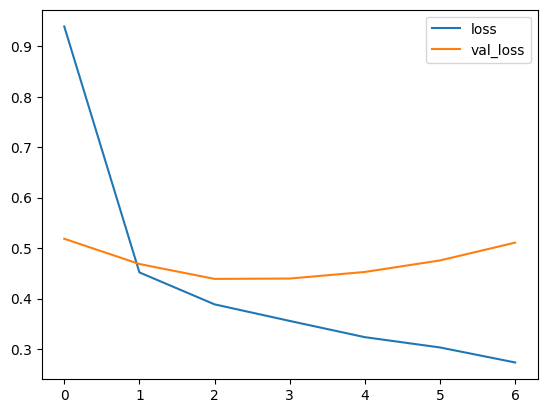

In [ ]:
bi_gru_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')])

bi_gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 21ms/step - loss: 0.5400 - accuracy: 0.8297
Test Loss: 0.5399513840675354
Test Accuracy: 0.8297145366668701


## LSTM

Epoch 1/10
385/385 [==============================] - 45s 104ms/step - loss: 1.0538 - accuracy: 0.7570 - val_loss: 0.5555 - val_accuracy: 0.8272
Epoch 2/10
385/385 [==============================] - 24s 63ms/step - loss: 0.5707 - accuracy: 0.8037 - val_loss: 0.5269 - val_accuracy: 0.8119
Epoch 3/10
385/385 [==============================] - 17s 44ms/step - loss: 0.5319 - accuracy: 0.8304 - val_loss: 0.4985 - val_accuracy: 0.8424
Epoch 4/10
385/385 [==============================] - 17s 45ms/step - loss: 0.4583 - accuracy: 0.8543 - val_loss: 0.4798 - val_accuracy: 0.8343
Epoch 5/10
385/385 [==============================] - 13s 33ms/step - loss: 0.4263 - accuracy: 0.8594 - val_loss: 0.4705 - val_accuracy: 0.8411
Epoch 6/10
385/385 [==============================] - 13s 34ms/step - loss: 0.3980 - accuracy: 0.8672 - val_loss: 0.4806 - val_accuracy: 0.8353

Final val_accuracy: 83.53%



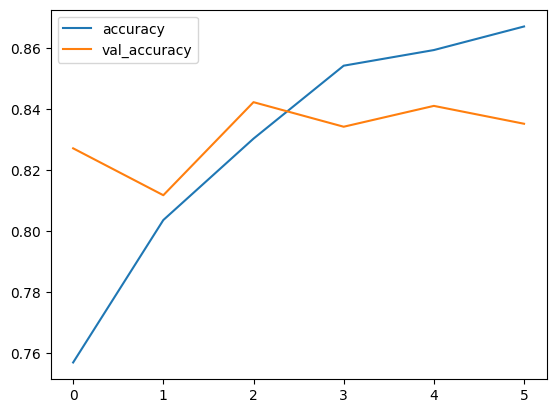

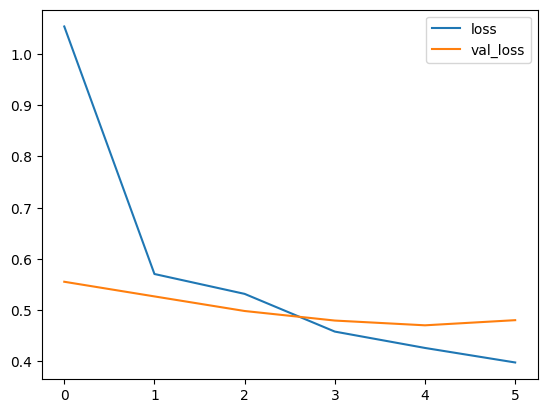

In [ ]:
lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    LSTM(64),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 11ms/step - loss: 0.5006 - accuracy: 0.8265
Test Loss: 0.5005931854248047
Test Accuracy: 0.8265430331230164


## Dvosmjerni LSTM

Epoch 1/10
385/385 [==============================] - 56s 121ms/step - loss: 1.0198 - accuracy: 0.8059 - val_loss: 0.5195 - val_accuracy: 0.8516
Epoch 2/10
385/385 [==============================] - 28s 72ms/step - loss: 0.4788 - accuracy: 0.8581 - val_loss: 0.4805 - val_accuracy: 0.8499
Epoch 3/10
385/385 [==============================] - 24s 62ms/step - loss: 0.4292 - accuracy: 0.8675 - val_loss: 0.4731 - val_accuracy: 0.8411
Epoch 4/10
385/385 [==============================] - 22s 56ms/step - loss: 0.3910 - accuracy: 0.8757 - val_loss: 0.4647 - val_accuracy: 0.8572
Epoch 5/10
385/385 [==============================] - 19s 49ms/step - loss: 0.3575 - accuracy: 0.8899 - val_loss: 0.4746 - val_accuracy: 0.8443
Epoch 6/10
385/385 [==============================] - 20s 52ms/step - loss: 0.3382 - accuracy: 0.8993 - val_loss: 0.4692 - val_accuracy: 0.8499
Epoch 7/10
385/385 [==============================] - 18s 47ms/step - loss: 0.3161 - accuracy: 0.9037 - val_loss: 0.4637 - val_accuracy

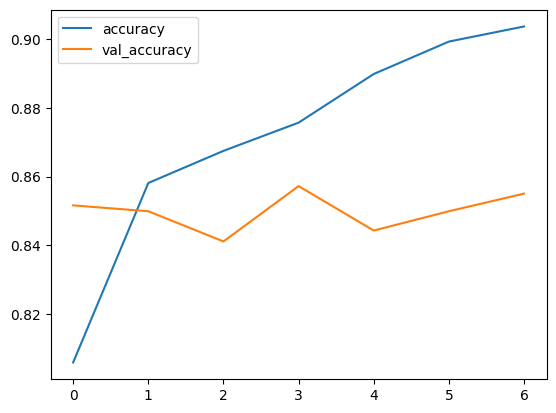

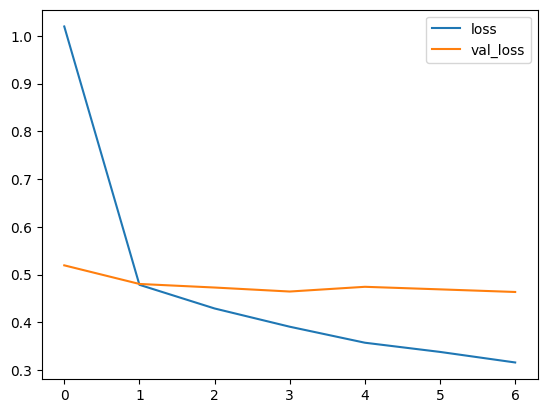

In [ ]:
bi_lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.4728 - accuracy: 0.8495
Test Loss: 0.4727649986743927
Test Accuracy: 0.8494755029678345


## GloVe

In [12]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-11 09:24:40--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-11 09:24:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 38s  

2024-01-11 09:27:19 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [13]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [14]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [15]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

## BiGRU model sa GloVe vektorima

Epoch 1/10
385/385 [==============================] - 17s 35ms/step - loss: 0.6160 - accuracy: 0.7685 - val_loss: 0.4795 - val_accuracy: 0.8194
Epoch 2/10
385/385 [==============================] - 13s 33ms/step - loss: 0.4665 - accuracy: 0.8249 - val_loss: 0.4398 - val_accuracy: 0.8282
Epoch 3/10
385/385 [==============================] - 12s 30ms/step - loss: 0.4073 - accuracy: 0.8444 - val_loss: 0.3978 - val_accuracy: 0.8482
Epoch 4/10
385/385 [==============================] - 12s 31ms/step - loss: 0.3779 - accuracy: 0.8564 - val_loss: 0.3748 - val_accuracy: 0.8575
Epoch 5/10
385/385 [==============================] - 12s 32ms/step - loss: 0.3456 - accuracy: 0.8703 - val_loss: 0.3755 - val_accuracy: 0.8533
Epoch 6/10
385/385 [==============================] - 12s 32ms/step - loss: 0.3221 - accuracy: 0.8760 - val_loss: 0.3799 - val_accuracy: 0.8514

Final val_accuracy: 85.14%



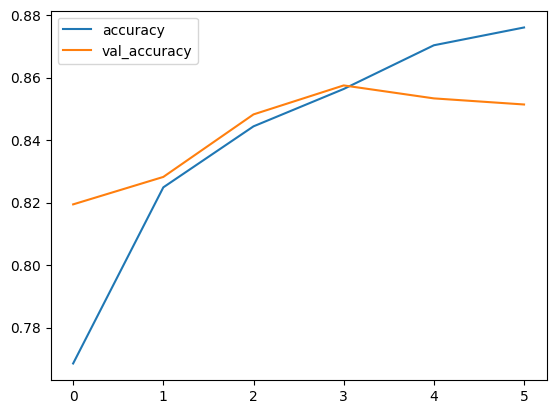

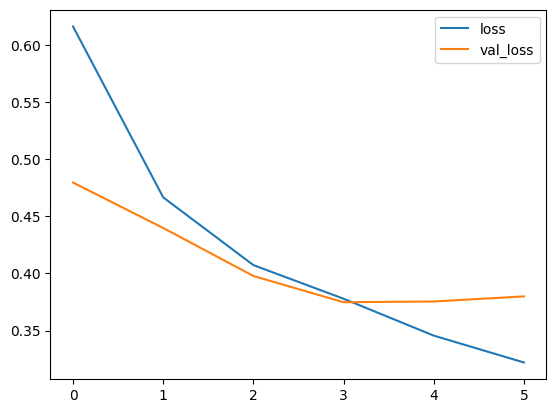

In [ ]:
gru_model_glove1 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

gru_model_glove1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove1.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = gru_model_glove1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 14ms/step - loss: 0.3834 - accuracy: 0.8544
Test Loss: 0.3833511173725128
Test Accuracy: 0.854354739189148


## BiLSTM model sa GloVe vektorima

Epoch 1/10
385/385 [==============================] - 22s 43ms/step - loss: 1.2384 - accuracy: 0.7509 - val_loss: 0.7478 - val_accuracy: 0.7962
Epoch 2/10
385/385 [==============================] - 14s 35ms/step - loss: 0.6215 - accuracy: 0.7980 - val_loss: 0.5680 - val_accuracy: 0.8070
Epoch 3/10
385/385 [==============================] - 16s 42ms/step - loss: 0.5691 - accuracy: 0.8100 - val_loss: 0.5198 - val_accuracy: 0.8194
Epoch 4/10
385/385 [==============================] - 14s 35ms/step - loss: 0.5343 - accuracy: 0.8185 - val_loss: 0.4883 - val_accuracy: 0.8411
Epoch 5/10
385/385 [==============================] - 14s 36ms/step - loss: 0.5081 - accuracy: 0.8254 - val_loss: 0.5280 - val_accuracy: 0.8253
Epoch 6/10
385/385 [==============================] - 14s 35ms/step - loss: 0.4762 - accuracy: 0.8339 - val_loss: 0.4615 - val_accuracy: 0.8421
Epoch 7/10
385/385 [==============================] - 14s 35ms/step - loss: 0.4544 - accuracy: 0.8446 - val_loss: 0.4637 - val_accuracy:

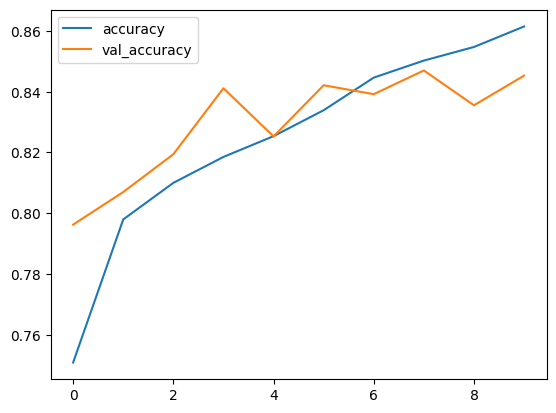

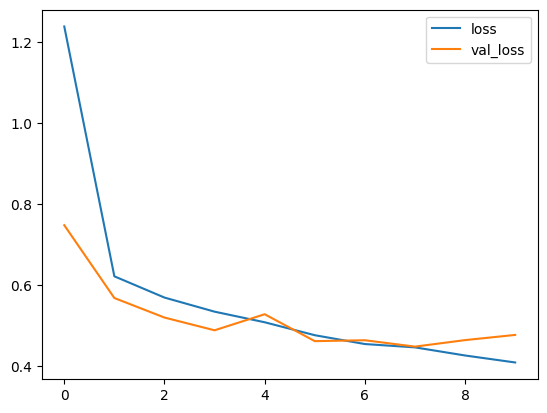

In [ ]:
bi_lstm_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model_glove.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.4966 - accuracy: 0.8409
Test Loss: 0.49656540155410767
Test Accuracy: 0.8409368395805359
